### Bathe-Ansatz at Finite temperature
-- Evaluated at half-filling and $S_z = 0$.
      (Referece: https://journals.jps.jp/doi/10.1143/JPSJ.59.1357)

#### NOTE that U = U/4 here (we first keep the scaling)

The grand potential per site is evaluated by

\begin{equation}
\Omega = e_0 - \mu - \int_{-\pi}^{\pi} \rho_0(k)G[\kappa(k)]dk
 - \int_{-\infty}^{\infty} \sigma_0(\Lambda)[\varepsilon_1^{-}(\Lambda) - T\ln b_1^{-}]d\Lambda
\end{equation}
where $e_0$, $\rho_0(k)$, $\sigma_0(\Lambda)$ are ground state quantities that can be evaluated from ground state BA.

The other quantities in the integrations are defined as following

\begin{equation}
G(y) = T\ln [1+\exp(y/T)], \hspace{0.5cm} b_n^{\pm} = \frac{\sinh^2 x^{\pm}}{\sinh^2 (n+1)x^{\pm}}  \hspace{0.3cm} \left(=\frac{1}{(n+1)^2} \text{ if } x^{\pm} = 0\right)
\end{equation}

\begin{equation}
\kappa(k) = \kappa_0(k) + T\ln\left(\frac{\cosh x^+}{\cosh x^-}\right) + \int_{-\infty}^{\infty}s(\Lambda-\sin k)
[\varepsilon^+_1(\Lambda)-\varepsilon^-_1(\Lambda)] d\Lambda
\end{equation}

where
\begin{equation}
\kappa_0(k) = -2\cos k - 4\int_{-\infty}^{\infty} s(\Lambda -\sin k)\Re [1 - (\Lambda - iU)^2]^{1/2} d\Lambda
\end{equation}

\begin{equation}
\varepsilon_n^{\pm}(\Lambda) = T\ln \{b_n^{\pm}+(1-b_n^{\pm})\exp[E_n^{\pm}(\Lambda)/T]\} \hspace{0.3cm} \text{for} \hspace{0.3cm} n\geq 1
\end{equation}

\begin{equation}
E_1^{\pm}(\Lambda) = s*\varepsilon_2^{\pm}(\Lambda) - \int_{-\pi}^{\pi} \cos(k)  s(\Lambda - \sin k)G[\pm \kappa(k)]d k
\end{equation}

and 
\begin{equation}
E_n^{\pm}(\Lambda) = s*(\varepsilon_{n-1}^{\pm} + \varepsilon_{n+1}^{\pm}) \hspace{0.5cm} \text{for} \hspace{0.5cm} n\geq 2
\end{equation}

\begin{equation}
x^+ = (2U-\mu)/T \hspace{0.3cm} (=0 \text{ if half-filling} ), \hspace{0.5cm} x^- = 0
\end{equation}
and
\begin{equation}
s*f = \int_{-\infty}^{\infty} s(\Lambda - \Lambda')f(\Lambda')d\Lambda'
\end{equation}

#### Asymptotic conditions
\begin{equation}
\lim_{\Lambda \rightarrow \infty}\varepsilon_n^{\pm}(\Lambda) = 0
\end{equation}

\begin{equation}
\lim_{n\rightarrow \infty} \left[\varepsilon^{\pm}_{n+1}(\Lambda) - \int_{\infty}^{\infty} \varepsilon_n^{\pm}(\Lambda') \frac{U/\pi}{(\Lambda' - \Lambda)^2 + U^2}d\Lambda'\right] = 0
\end{equation}
which gives $\epsilon_n^{\pm}\rightarrow 0$ as $n\rightarrow \infty$. $n=12$ is quiet enough.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

### Implementation
#### 1. Solve ground state
half-filling is much easier with the Bessel functions

#### 2. Solve for $\varepsilon_n^{\pm}$, $E_n^{\pm}$ and $\kappa(k)$.

First try: 
1. Initial guess: E, $\varepsilon$ all zero. 
2. Calculate $\kappa$.
3. Solve for $E_n^{\pm}$ and $\varepsilon_n^{\pm}$ with $n = 1, ..., N_m$ assuming $\varepsilon_{N_m+1}^{\pm}=0$.
4. Repeat Step 2 and Step 3 until convergence.
5. Compare $\kappa$ or $\varepsilon_1$ to determine convergence

In [75]:
class BetheAnsatzFT(object):
    # half-filling, Sz = 0
    def __init__(self, U, T, ngrid):
        self.U = U/4.
        self.T = T
        self.ngrid = ngrid
        self.Q = np.pi
        self.B = 10
        self.kgrid = np.zeros(ngrid)
        self.lgrid = np.zeros(ngrid)
        self.dk = 2.*self.Q / ngrid
        self.dl = 2.*self.B / ngrid
        #some functions used in integration functions
        self.kappa0 = np.zeros(ngrid)
        self.kappa = np.zeros(ngrid)
        self.eps1m = np.zeros(ngrid)
        self.sig0 = np.zeros(ngrid)
        self.rho0 = np.zeros(ngrid)
        self.e0 = 0.
        self.grandpot = 0.
    
    def generate_grids(self):
        # symmetrized partition
        self.kgrid = np.linspace(-self.Q, self.Q, self.ngrid, endpoint=False)
        self.lgrid = np.linspace(-self.B, self.B, self.ngrid, endpoint=False)
        self.kgrid += self.dk/2.
        self.lgrid += self.dl/2.
        
    def get_sig0(self):
        sig0 = np.zeros(self.ngrid)
        i = 0
        for l in self.lgrid:
            sig0[i] = np.sum(self.sfunc(l, np.sin(self.kgrid)))*self.dk/(2.*np.pi)
            i += 1
        self.sig0 = sig0
        return sig0
    def get_rho0(self):
        sig0 = self.sig0
        if(np.linalg.norm(sig0)<1e-9):
            sig0 = self.get_sig0()
        rho0 = np.zeros(self.ngrid)
        i = 0
        for k in self.kgrid:
            #print 1./((self.lgrid-np.sin(k))**2+self.U**2).shape
            rho0[i] = (self.U*self.dl*np.cos(k)/np.pi)* np.dot(sig0, 1./((self.lgrid-np.sin(k))**2+self.U**2))
            
            i += 1
        rho0 += 1./(2.*np.pi)
        self.rho0 = rho0
        return rho0
    def get_e0(self):
        rho0 = self.rho0
        if(np.linalg.norm(rho0) < 1e-9):
            rho0 = self.get_rho0()
        e0 = -2.*self.dk*np.dot(np.cos(self.kgrid), rho0)
        self.e0 = e0
        return e0
        
    def get_grandpot(self):
        part1 = self.dk*np.dot(self.rho0, self.Gfunc(self.kappa))
        part2 = self.dl*np.dot(self.sig0, self.eps1m-self.T*np.log(1./4.))
        Omega = self.e0 - self.U*2. - part1 - part2
        self.grandpot = Omega
        return Omega
    
    def sfunc(self, l, k):
        self.s = 1./(4.*self.U*np.cosh(np.pi*(l-k)/(2*self.U)))
        return self.s
    def kappa0func(self):
        kappa0 = np.zeros(self.ngrid)
        i = 0
        for k in self.kgrid:
            kappa0[i] = -2.*np.cos(k) - 4.*self.dl*np.dot(self.sfunc(self.lgrid,np.sin(k)),np.sqrt(1.-(self.lgrid-1.j*self.U)**2).real)
            i+=1
        self.kappa0 = kappa0
        return kappa0
    def Gfunc(self, y):
        return self.T * np.log(1.+np.exp(y/self.T))
    def sconvfunc(self, fl):
        convf = np.zeros(self.ngrid)
        i = 0
        for l in self.lgrid:
            convf[i] = self.dl*np.dot(self.sfunc(l, self.lgrid), fl)
            i += 1
        return convf
    # functions to be used in self-consistency
    def kappafunc(self, eps1p, eps1m):
        kappa = np.zeros(self.ngrid)
        self.kappa0 = self.kappa0func()
        i = 0
        for k in self.kgrid:
            kappa[i] = self.dl * np.dot(self.sfunc(self.lgrid, np.sin(k)), eps1p-eps1m)
            i += 1
        self.kappa = kappa + self.kappa0
        return self.kappa
    
    def epsnfunc(self, n, En):
        bn = 1./((n+1.)**2)
        return self.T * np.log(bn + (1-bn)*np.exp(En/self.T))
    def E1func(self, eps2, p=1.):
        # p : parity
        E1 = np.zeros(self.ngrid)
        i = 0
        for l in self.lgrid:
            E1[i] = -self.dk * np.dot(np.cos(self.kgrid)*self.sfunc(l,np.sin(self.kgrid)), self.Gfunc(p*self.kappa))
            i += 1

        E1 += self.sconvfunc(eps2)
        return E1
    def Enfunc(self, epsm, epsp):
        return self.sconvfunc(epsm + epsp)
   
    def solve_epsilon_scf(self, nstep=100, tol = 1e-5):
    
        print "Calculating epsilon and kappa..."
        nmax  = 20
        ngrid = self.ngrid
        Ep   = np.zeros((nmax+1, ngrid))
        Em   = np.zeros((nmax+1, ngrid))
        epsp = np.zeros((nmax+1, ngrid))
        epsm = np.zeros((nmax+1, ngrid))
        # initial guess: eps1p = eps1m, high orders are zero
        kappa = self.kappa.copy()
        for itr in range(nstep):
            self.kappa = self.kappafunc(epsp[0], epsm[0])
            Ep[0] = self.E1func(epsp[1], 1.)
            Em[0] = self.E1func(epsm[1], -1.)
            epsp[0] = self.epsnfunc(1, Ep[0])
            epsm[0] = self.epsnfunc(1, Em[0])
            for i in range(1, nmax):
                Ep[i] = self.sconvfunc(epsp[i-1]+epsp[i+1])
                Em[i] = self.sconvfunc(epsm[i-1]+epsm[i+1])
                epsp[i] = self.epsnfunc(i+1, Ep[i])
                epsm[i] = self.epsnfunc(i+1, Em[i])
            diff = np.linalg.norm(self.kappa - kappa)
            #print diff
            if diff < tol:
                print "The convergence is achieved after %d loops!"%(itr+1), "Final diff:", diff
                break
            else:
                kappa = self.kappa.copy()
        if(itr == nstep-1):
            print "The convergence is NOT acheived after %d loops!"%nstep, "Final diff:", diff
        self.eps1m = np.copy(epsm[0])
    def solve_grandpot(self):
        self.generate_grids()
        self.solve_epsilon_scf()
        self.e0 = self.get_e0()
        grandpot = self.get_grandpot()
        return grandpot

In [76]:
def solve_energy_curve(U, ngrid=60):
    Tgrid = np.linspace(0.1, 1, 10)
    dT = 0.01
    entropy = []
    grandpot = []
    
    for T in Tgrid:
        obj = BetheAnsatzFT(U, T, ngrid)
        g = obj.solve_grandpot()
        grandpot.append(g)
        objp = BetheAnsatzFT(U, T+dT, ngrid)
        objm = BetheAnsatzFT(U, T-dT, ngrid)
        s = -(objp.solve_grandpot() - objm.solve_grandpot())/(2*dT)
        entropy.append(s)
    entropy = np.asarray(entropy)
    grandpot = np.asarray(grandpot)
    energy = grandpot + U/2. + Tgrid*entropy
    print energy
    plt.plot(Tgrid, energy)
        
    

Calculating epsilon and kappa...
The convergence is achieved after 16 loops! Final diff: 8.24248803406e-06
Calculating epsilon and kappa...
The convergence is achieved after 16 loops! Final diff: 9.90468733462e-06
Calculating epsilon and kappa...
The convergence is achieved after 15 loops! Final diff: 8.21069115956e-06
Calculating epsilon and kappa...
The convergence is achieved after 24 loops! Final diff: 9.23697308987e-06
Calculating epsilon and kappa...
The convergence is achieved after 25 loops! Final diff: 8.98156076349e-06
Calculating epsilon and kappa...
The convergence is achieved after 23 loops! Final diff: 9.50275497949e-06
Calculating epsilon and kappa...
The convergence is achieved after 31 loops! Final diff: 9.46513277841e-06
Calculating epsilon and kappa...
The convergence is achieved after 32 loops! Final diff: 9.1288856182e-06
Calculating epsilon and kappa...
The convergence is achieved after 30 loops! Final diff: 9.81581100834e-06
Calculating epsilon and kappa...
The c

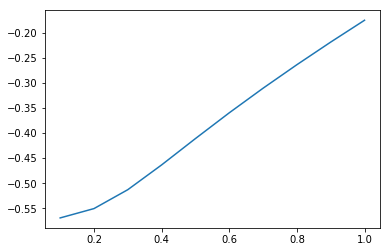

In [77]:
solve_energy_curve(4)